In [1]:
import libsumo
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.hyperparameters import (
    SingleObjectiveSingleRun,
    HyperparameterProblem,
)
from pymoo.algorithms.soo.nonconvex.optuna import Optuna
from pymoo.core.parameters import set_params, hierarchical, get_params
from pymoo.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

MASSIVE_TRAFFIC_PATH = "../sumo_conf/massive-traffic/massive.sumocfg"


class SumoContext:
    def __init__(self, config_path):
        self.config_path = config_path

    def __enter__(self):
        libsumo.start(["sumo", "-c", self.config_path])
        return libsumo

    def __exit__(self, exc_type, exc_val, exc_tb):
        libsumo.close()

In [16]:
RED = "r"
YELLOW = "y"
GREEN = "G"
YELLOW_TIME = 3

In [17]:
def function_fitness(config, min_cars, min_time, max_time, change_ratio):
    with SumoContext(config) as sumo:
        tf_id = sumo.trafficlight_getIDList()[0]
        logic = sumo.trafficlight_getAllProgramLogics(tf_id)[0]
        phase = logic.phases[0]
        current_state = [s for i, s in enumerate(phase.state) if i % 5 != 4]
        current_time = [0 for _ in range(len(current_state))]
        current_change = ["" for _ in range(len(current_state))]
        lanes = [i for i in range(16)]
        base_conflicts = {
            0: [5],
            1: [5, 6, 11, 12, 13, 14, 15],
            2: [5, 6, 7, 11, 13, 14, 15],
            3: [5, 6, 7, 9, 10, 14, 15],
        }
        total_wt = 0
        total_veh = 0

        def get_conflicts(lane_id):
            if base_conflicts.get(lane_id) is not None:
                return base_conflicts[lane_id]
            return [(i + 4 * (lane_id // 4)) % 16 for i in base_conflicts[lane_id % 4]]

        def lane_to_light(lane_id):
            if lane_id < 3:
                return [lane_id]
            if lane_id == 3:
                return [lane_id, lane_id + 1]
            if lane_id < 7:
                return [lane_id + 1]
            if lane_id == 7:
                return [lane_id + 1, lane_id + 2]
            if lane_id < 11:
                return [lane_id + 2]
            if lane_id == 11:
                return [lane_id + 2, lane_id + 3]
            if lane_id < 15:
                return [lane_id + 3]
            return [lane_id + 3, lane_id + 4]

        def change_state(lane, state):
            current_state[lane] = state
            for light_id in lane_to_light(lane):
                phase.state = (
                    phase.state[:light_id] + state + phase.state[light_id + 1 :]
                )
                sumo.trafficlight.setProgramLogic(tf_id, logic)

        def change_to_yellow(lane, change_to):
            change_state(lane, YELLOW)
            current_change[lane] = change_to
            current_time[lane] = 0

        def should_be_candidate(lane, lane_waiting):
            if lane_waiting > min_cars or current_time[lane] > max_time:
                conflicts = get_conflicts(lane)
                for conflict in conflicts:
                    if current_change[conflict] == GREEN:
                        break
                    if current_state[conflict] == GREEN:
                        if current_time[conflict] < min_time:
                            break
                        conflict_waiting = sumo.lane.getLastStepVehicleNumber(
                            str(conflict)
                        )
                        if (
                            conflict_waiting > 0
                            and lane_waiting > 0
                            and conflict_waiting / lane_waiting > change_ratio
                        ):
                            break
                else:
                    return True
            return False

        def change_candidates(step_changes):
            step_changes.sort(key=lambda x: x[1], reverse=True)
            for lane, _ in step_changes:
                if current_state[lane] == YELLOW:
                    continue
                change_to_yellow(lane, GREEN)
                for conflict in get_conflicts(lane):
                    if current_state[conflict] != GREEN:
                        continue
                    change_to_yellow(conflict, RED)

        def get_waiting_vehicles():
            nonlocal total_wt, total_veh
            for veh_id in sumo.vehicle.getIDList():
                if sumo.vehicle.getSpeed(veh_id) < 0.1:
                    total_wt += 1
            total_veh += sumo.simulation.getArrivedNumber()

        def update_times():
            for lane in lanes:
                if current_state[lane] == YELLOW and current_time[lane] == YELLOW_TIME:
                    change_state(lane, current_change[lane])
                    current_change[lane] = ""
                    current_time[lane] = 0
                else:
                    current_time[lane] += 1

        for i in range(3600):
            # go through all lanes and check if they are candidates for changing
            step_changes = []
            for lane in lanes:
                if current_state[lane] == RED:
                    lane_waiting = sumo.lane.getLastStepVehicleNumber(str(lane))
                    if should_be_candidate(lane, lane_waiting):
                        step_changes.append((lane, lane_waiting))

            # change the state of the candidates, on conflict change only the light on the line that has longer queue
            change_candidates(step_changes)

            sumo.simulationStep()

            get_waiting_vehicles()

            # update time for lights, change yellow if needed
            update_times()

    return total_wt / total_veh

In [26]:
class SumoDynamicProblem(ElementwiseProblem):
    def __init__(self, config):
        super().__init__(
            n_var=4,
            n_obj=1,
            xl=np.array([0, 5, 30, 0.1]),
            xu=np.array([10, 60, 300, 10]),
        )
        self.config = config

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = function_fitness(
            config=self.config,
            min_cars=x[0],
            min_time=x[1],
            max_time=x[2],
            change_ratio=x[3],
        )


ga = GA(pop_size=50, eliminate_duplicates=True)
problem = SumoDynamicProblem(MASSIVE_TRAFFIC_PATH)

In [27]:
ga_base = minimize(
    problem=problem,
    algorithm=ga,
    seed=1,
    termination=("n_eval", 1000),
    verbose=True,
    save_history=True,
)
print("Best solution found for GA base: \nX = %s\nF = %s" % (ga_base.X, ga_base.F))

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       50 |  1.028059E+02 |  7.355464E+01
     2 |      100 |  9.178975E+01 |  7.355464E+01
     3 |      150 |  8.608653E+01 |  7.355464E+01
     4 |      200 |  7.948489E+01 |  6.992252E+01
     5 |      250 |  7.517395E+01 |  6.915791E+01
     6 |      300 |  7.302357E+01 |  6.815718E+01
     7 |      350 |  7.117610E+01 |  6.726445E+01
     8 |      400 |  7.015164E+01 |  6.726445E+01
     9 |      450 |  6.907170E+01 |  6.726445E+01
    10 |      500 |  6.858135E+01 |  6.703075E+01
    11 |      550 |  6.832104E+01 |  6.703075E+01
    12 |      600 |  6.798034E+01 |  6.703075E+01
    13 |      650 |  6.790235E+01 |  6.703075E+01
    14 |      700 |  6.781330E+01 |  6.703075E+01
    15 |      750 |  6.772219E+01 |  6.703075E+01
    16 |      800 |  6.759947E+01 |  6.703075E+01
    17 |      850 |  6.752279E+01 |  6.703075E+01
    18 |      900 |  6.733583E+01 |  6.703075E+01
    19 |      950 |  6.716799E+01 |  6.703075E+01


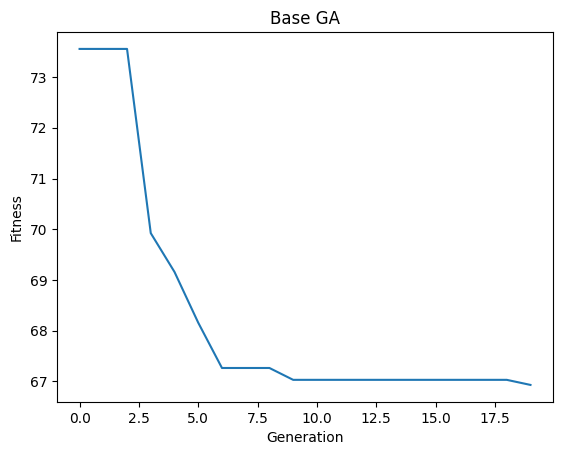

In [28]:
val = [e.opt.get("F")[0] for e in ga_base.history]
plt.plot(np.arange(len(val)), val)
plt.title("Base GA")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.show()

In [29]:
performance = SingleObjectiveSingleRun(problem, termination=("n_evals", 200), seed=1)

res = minimize(
    HyperparameterProblem(ga, performance),
    Optuna(),
    termination=("n_evals", 10),
    seed=1,
    verbose=True,
)

hyperparams = res.X
print(hyperparams)
set_params(ga, hierarchical(hyperparams))

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        1 |  7.027577E+01 |  7.027577E+01
     2 |        2 |  7.196245E+01 |  7.027577E+01
     3 |        3 |  6.923899E+01 |  6.923899E+01
     4 |        4 |  7.293898E+01 |  6.923899E+01
     5 |        5 |  6.907830E+01 |  6.907830E+01
     6 |        6 |  7.203060E+01 |  6.907830E+01
     7 |        7 |  7.155894E+01 |  6.907830E+01
     8 |        8 |  6.813345E+01 |  6.813345E+01
     9 |        9 |  7.024722E+01 |  6.813345E+01
    10 |       10 |  6.697093E+01 |  6.697093E+01
{'mating.mutation.eta': 14.182840277226372, 'mating.mutation.prob': 0.7149860376838261, 'mating.crossover.prob_bin': 0.5358964059155116, 'mating.crossover.prob_exch': 0.6637946452197888, 'mating.crossover.eta': 16.90200602557433, 'mating.crossover.prob_var': 0.8556758047926507, 'mating.crossover.prob': 0.7932775202509965}


In [30]:
ga_tuned = minimize(
    problem=problem,
    algorithm=ga,
    seed=1,
    termination=("n_eval", 1000),
    verbose=True,
    save_history=True,
)
print("Best solution found for GA tuned: \nX = %s\nF = %s" % (ga_tuned.X, ga_tuned.F))

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       50 |  1.028059E+02 |  7.355464E+01
     2 |      100 |  9.164200E+01 |  7.355464E+01
     3 |      150 |  8.539412E+01 |  7.114092E+01
     4 |      200 |  7.949418E+01 |  6.697093E+01
     5 |      250 |  7.527863E+01 |  6.697093E+01
     6 |      300 |  7.272970E+01 |  6.697093E+01
     7 |      350 |  7.172197E+01 |  6.697093E+01
     8 |      400 |  7.101132E+01 |  6.697093E+01
     9 |      450 |  7.028288E+01 |  6.697093E+01
    10 |      500 |  6.960544E+01 |  6.697093E+01
    11 |      550 |  6.905968E+01 |  6.697093E+01
    12 |      600 |  6.826891E+01 |  6.697093E+01
    13 |      650 |  6.698101E+01 |  6.697093E+01
    14 |      700 |  6.697093E+01 |  6.697093E+01
    15 |      750 |  6.697093E+01 |  6.697093E+01
    16 |      800 |  6.697093E+01 |  6.697093E+01
    17 |      850 |  6.697093E+01 |  6.697093E+01
    18 |      900 |  6.697093E+01 |  6.697093E+01
    19 |      950 |  6.697093E+01 |  6.697093E+01


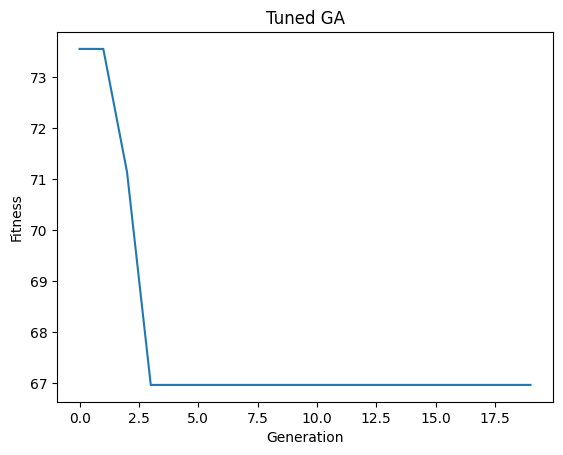

In [31]:
val = [e.opt.get("F")[0] for e in ga_tuned.history]
plt.plot(np.arange(len(val)), val)
plt.title("Tuned GA")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.show()